# Lab 5: Line Fitting and RANSAC

## NOTE: Problems below are mostly coding excersices where you should implement and/or test different standard methods for model fitting on examples with synthetic data. The problems below were primarily designed to help the students learn the basics of model parameter estimation in a much more basic context - simple line models and 2D data points (synthetic).
### While the provided initial notebook shows synthetic and real examples of 2D data points for line fitting, you might need to restart the nootebook (Kernel->Restart and Clear Output).

## Problem 1: least-squares and line fitting in 2D (synthetic data without outliers)
### Complete implementation of function $estimate$ of class $LeastSquareLine$ in the second cell below. It should update line parameters $a$ and $b$ correpsonding to line model $y=ax+b$. You can use either SVD of matrix $A$ or inverse of matrix $A^T A$, as mentioned in class. NOTE: several cells below test your code.

In [264]:
%matplotlib inline

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
from skimage.measure import ransac

#### TO IMPLEMENT: complete (fix) the code in the following cell. Note that solution has 2-3 lines. You can use $svd$ function in $la$ and/or standard matrix operations from $np$.

In [265]:
class LeastSquareLine:

    def __init__(self):
        self.a = 0.0
        self.b = 0.0

    def estimate(self, points2D):
        B = points2D[:,1]
        A = np.copy(points2D)
        A[:,1] = 1.0

        # Vector B and matrix A are already defined. Change code below
        # pseudo inverse is generalized inverse, for matrices that may not have a unique inverse
        pseudo_inverse = np.linalg.inv(np.dot(A.T, A)) 
        weights = np.dot(pseudo_inverse, A.T)
        coeffs = np.dot(weights, B)
        self.a, self.b = coeffs
        return True

    def predict(self, x): return (self.a * x) + self.b

    def predict_y(self, x): return (self.a * x) + self.b

    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])

    def line_par(self):
        return self.a, self.b

#### Working code below generates (simulates) data points in $R^2$ corresponding to noisy observations of a line.

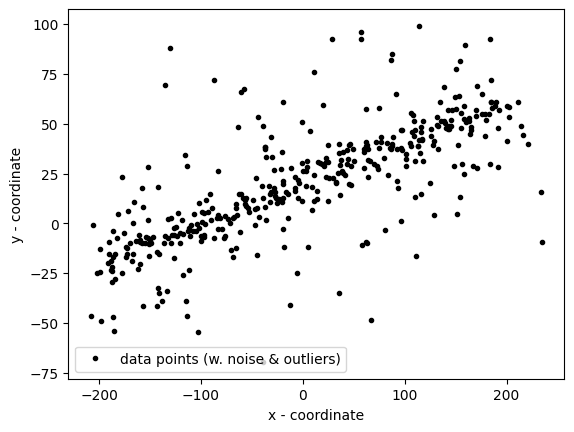

In [266]:
np.random.seed(seed=1)

# parameters for "true" line y = a*x + b
a, b = 0.2, 20.0

# x-range of points [x1,x2]
x_start, x_end = -200.0, 200.0

# generate "idealized" line points
x = np.arange(x_start,x_end)
y = a * x + b
data = np.column_stack([x, y])    # staking data points into (Nx2) array

# add gaussian pertubations to generate "realistic" data points (noisy line observations)
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data += 5 * noise
data[::2] += 10 * noise[::2]  # every second point adds noise with variance 5
data[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

# IMPORTANT COMMENT!!!!!!!:
# the data now combines line points with different levels of additive Gaussie noise.
# Consider all these points as noisy inliers.
# Do not consider any of these as outliers. The outliers are added in Problem 4.


fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

#### Use the following code-cell to test your implementation of class $LeastSquareLine$ in Problem 3 for line fitting when observed data is noisy. The estimated line is displayed in the cell above.  Note that the initial result shown in Fig.1 of the provided notebook corresponds to the line $a=0,b=0$ returned by initial code for $LeastSquareLine$.  Your correct solution for $LeastSquareLine$ should return a line very close to the known (ground-truth) line model.

True


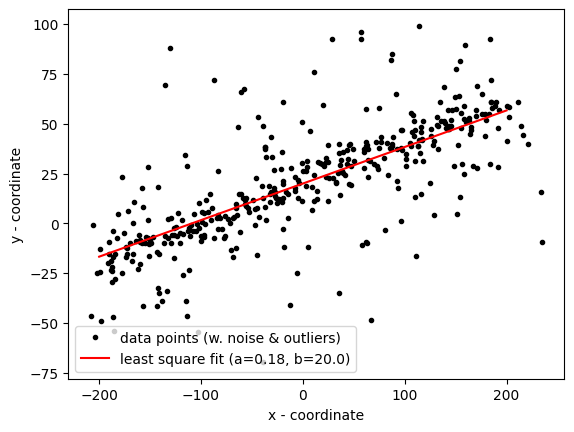

In [267]:
LSline = LeastSquareLine() # uses class implemented in Problem 2
print (LSline.estimate(data))
a_ls, b_ls = LSline.line_par()

# visualizing estimated line
fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')

ends = np.array([x_start,x_end])
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

## Problem 2: RANSAC for robust line fitting in 2D (synthetic data with outliers)

#### Working code in the cell below corrupts data with outliers.

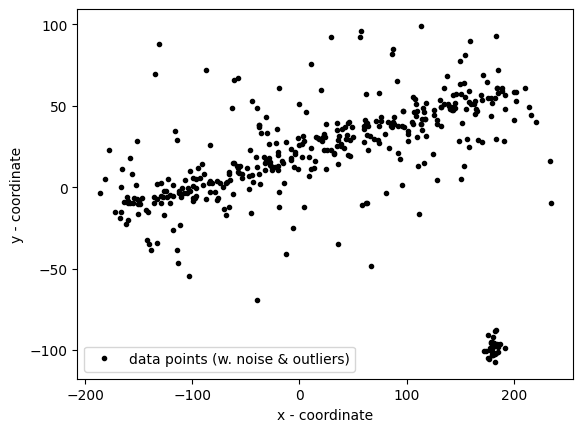

In [268]:
# add outliers
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data[:faulty.shape[0]] = faulty   # replacing the first 30 points in data with faulty (outliers)


fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

### NOTE: As clear from the code for data simulation, (creation of) outliers has nothing to do with the line. In contrast, all other points originate from some points on the true (perfect) line, see Probelm 1. The added Gaussian errors (large or small) simulate complex noise that commonly happens between true (but unknown) model and its real observations (data). The whole point of "model fitting" is to estimate (or restore) a "model" (e.g. line parameters) from its noisy observations (data). If data has no noise, it is trivial, e.g. only two line points would be enough to compute the line parameters exactly. In the presence of noise, one can use methods like least-squres to approximately estimate a line (parameters minimizing the loss functing summing squared $L_2$ errors), see Problem 1. However, if data is corrupted by outliers that have nothing to do with the model, as in Problem 2, more robust model fitting methods are needed, e.g. RANSAC.

#### The code below uses your implementation of class $LeastSquareLine$ from Probelm 1 for least-square line fitting when the data is corrupted with outliers. The estimated line is displayed in the cell above. Observe the differences with the result in Problem 1.

True


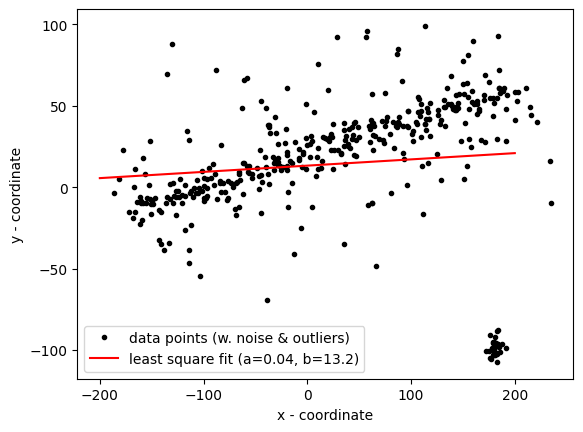

In [269]:
LSline = LeastSquareLine() # uses class implemented in Problem 2
print (LSline.estimate(data))
a_ls, b_ls = LSline.line_par()

# visualizing estimated line
fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')

ends = np.array([x_start,x_end])
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

### (part a) Assume that a set of $N=100$ points in $2D$ includes $N_i=20$ inliers for one line and $N_o=80$ outliers. What is the least number of times one should sample a random pair of points from the set to get probability $p\geq 0.95$ that in at least one of the sampled pairs both points are inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution:

see word doc

### (part b) Using the knowledge of the number of inliers/outliers in the example at the beginning of Problem 2, estimate the minimum number of sampled pairs needed to get RANSAC to "succeed" (to get at least one pair of inliers) with $p\geq 0.95$. Use your formula in part (a). Show your numbers in the cell below. Then, use your estimate as a value of parameter $max\text{_}trials$  inside function $ransac$ in the code cell below and test it.  You should also change $residual\text{_}threshold$ according to the noise level for inliers in the example. NOTE: the result is displayed in the same figure at the beginning of Problem 2.

Your estimates:

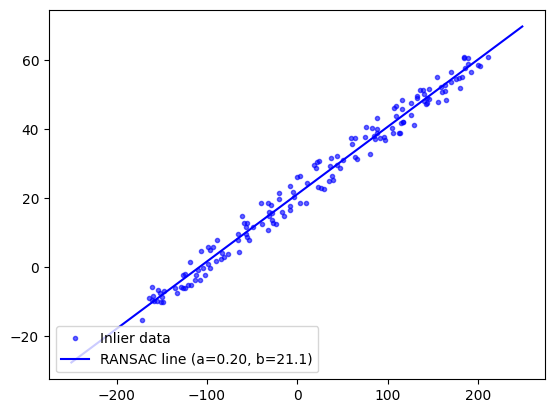

In [270]:
# robustly fit line using RANSAC algorithm
model_robust, inliers = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=5, max_trials=77)
a_rs, b_rs = model_robust.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust.predict_y(line_x)

fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.legend(loc='lower left')
plt.show()

## Problem 3: sequential RANSAC for robust multi-line fitting (synthetic data)

#### Adding data points supporting one more line

(800,) (603,) (800, 2) (417,)


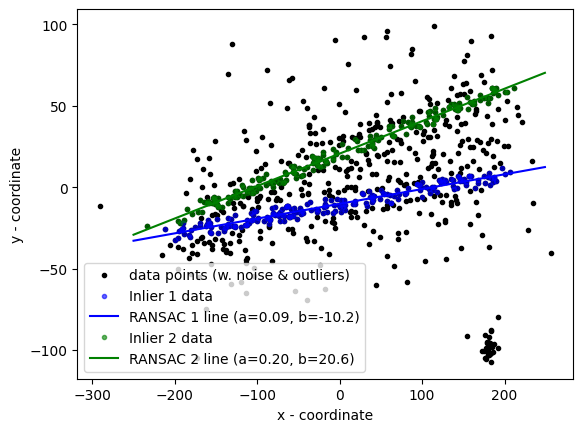

In [271]:
# parameters for "true" lines y = a*x + b
a2, b2 = 0.1, -10.0

# generate "idealized" line points
y2 = a2 * x + b2
data2 = np.column_stack([x, y2])    # staking data points into (Nx2) array

# add gaussian pertubations to generate "realistic" line data
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data2+= 5 * noise
data2[::2] += 10 * noise[::2]  # every second point adds noise with variance 5
data2[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

data = np.concatenate((data,data2)) # combining with previous data

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')


remaining = np.arange(len(data)) # initially all pts potential inliers
detected = [] # initially no points detected
m1, in1 = ransac(data[remaining], LeastSquareLine, min_samples=2, residual_threshold=5, max_trials=77)
a_rs1, b_rs1 = m1.line_par()
line_y_robust1 = m1.predict_y(line_x)
detected.append((m1, in1))
remaining = np.delete(remaining, in1) # remove detected points
remaining_data = np.delete(data, in1, axis=0)

m2, in2 = ransac(data[remaining], LeastSquareLine, min_samples=2, residual_threshold=5, max_trials=77)
a_rs2, b_rs2 = m2.line_par()
line_y_robust2 = m2.predict_y(line_x)
detected.append((m2, in2))
remaining = np.delete(remaining, in2) # remove detected points

print(in1.shape, in2.shape, data.shape, remaining.shape)
ax.plot(data[in1, 0], data[in1, 1], '.b', alpha=0.6, label='Inlier 1 data')
ax.plot(line_x, line_y_robust1, '-b', label='RANSAC 1 line (a={:4.2f}, b={:4.1f})'.format(a_rs1,b_rs1))
ax.plot(remaining_data[in2, 0], remaining_data[in2, 1], '.g', alpha=0.6, label='Inlier 2 data')
ax.plot(line_x, line_y_robust2, '-g', label='RANSAC 2 line (a={:4.2f}, b={:4.1f})'.format(a_rs2,b_rs2))
ax.legend(loc='best')


plt.show()

### Write code below using sequential RANSAC to detect two lines in the data above. Your lines should be displayed in the figure above (in Problem 3).